In [1]:
import numpy as np
import cv2
import glob
import time

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from skimage.feature import hog

from scipy.ndimage.measurements import label

from sklearn.utils import shuffle

#from helperfunctions import *

In [2]:
# Read in cars and notcars
cars = glob.glob('data/vehicles/*/*.png')
notcars = glob.glob('data/non-vehicles/*/*.png')

# Check that arrays are not empty
print(cars[0])
print(notcars[0])

print(len(cars)) #8792
print(len(notcars)) #8968

data/vehicles/GTI_Far/image0000.png
data/non-vehicles/Extras/extra1.png
8792
8968


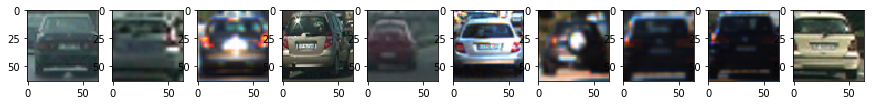

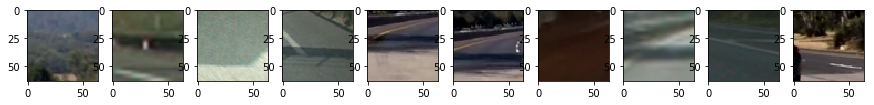

In [3]:
'''
Just for fun choose random car / not-car indices and plot example images   
''' 

sample_car = []
sample_notcar = []

for i in range(10):
    car_ind = np.random.randint(0, len(cars))
    notcar_ind = np.random.randint(0, len(notcars))
    
    sample_car.append(cars[car_ind])
    sample_notcar.append(notcars[car_ind])
    
    plt.figure(1, figsize=(15,15))
        
    # Read in car / not-car images
    car_image = mpimg.imread(cars[car_ind])
    plt.subplot(1, 10, i+1)
    plt.imshow(car_image)
    
    plt.figure(2, figsize=(15,15))
    notcar_image = mpimg.imread(notcars[notcar_ind])

    plt.subplot(1, 10, i+1)
    plt.imshow(notcar_image)
    
    i = i + 1 
plt.show()


In [4]:
print(len(sample_car))

10


In [5]:
'''
######################## extract hog features ############################################

using features.ravel(), which yields, in this case, a one dimensional array of length 1764.

Alternatively, you can set the feature_vector=True flag when calling the hog() function to automatically unroll the features.

'''

'\n######################## extract hog features ############################################\n\nusing features.ravel(), which yields, in this case, a one dimensional array of length 1764.\n\nAlternatively, you can set the feature_vector=True flag when calling the hog() function to automatically unroll the features.\n\n'

In [6]:
'''
input: image, HOG orientations, pixels per cell, cells per block (for normalization)
visualize def. false, feature vec (all along single access True)
output: the features (and potentially the hog image itself)
TODO: set transform_sqrt=True and remove neg numb
'''

# notice : img here accept only 2-D array, i.e. either gray or 1 of channels !

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [7]:
orient = 9
pix_per_cell = 8
cell_per_block = 2

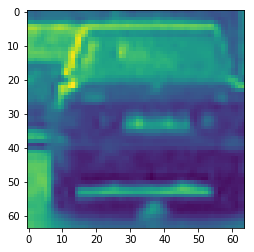

In [8]:
img0 = cv2.imread(sample_car[0])

#plt.imshow(img0)
gray = cv2.cvtColor(img0, cv2.COLOR_RGB2GRAY)
plt.imshow(gray)

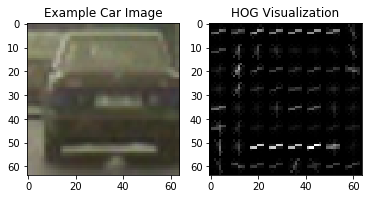

In [9]:

feature_sample0, hog_img0 = get_hog_features(gray, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        vis=True, feature_vec=True)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(img0, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_img0, cmap='gray')
plt.title('HOG Visualization')

In [10]:
print(feature_sample0, len(feature_sample0))

[ 0.0114451   0.00296981  0.00976997 ...,  0.00328353  0.00333311
  0.00130112] 1764


In [11]:
''' 

####### if feature_vec=False, no automatic features.ravel() for unroll,

print(feature_sample0 : 

[[[ 0.01820896  0.00445256  0.00420635 ...,  0.00528642  0.00598363
      0.00056947]
    [ 0.00252114  0.          0.00395168 ...,  0.00551057  0.00040267
      0.00113893]]

   [[ 0.00224864  0.          0.00192266 ...,  0.00892892  0.00778574
      0.00280379]
    [ 0.12938068  0.02780758  0.03662952 ...,  0.04721062  0.04778469
      0.10972855]]]


  [[[ 0.00246752  0.          0.00386764 ...,  0.00539338  0.00039411
      0.00111471]
    [ 0.00622099  0.00364668  0.00503646 ...,  0.00326154  0.00512825
      0.00111471]]

   [[ 0.12662919  0.02721621  0.03585054 ...,  0.04620661  0.04676847
      0.10739499]
    [ 0.00390671  0.00118233  0.0196294  ...,  0.00275735  0.00509119
      0.00215338]]]]



 [[[[ 0.0240946   0.02256829  0.00475711 ...,  0.0014748   0.00222624
      0.04418742]
    [ 0.00847524  0.01224661  0.01152073 ...,  0.01418636  0.0260503
      0.06008926]]

   [[ 0.00359591  0.00318516  0.01121211 ...,  0.00466764  0.          0.01788773]
    [ 0.00333906  0.          0.00239661 ...,  0.          0.00019145
      0.00274108]]]


  [[[ 0.00842405  0.01217264  0.01145115 ...,  0.01410068  0.02589295
      0.05972632]
    [ 0.00212749  0.00219175  0.0023575  ...,  0.00225446  0.00466228
      0.00461223]]

   [[ 0.00331889  0.          0.00238213 ...,  0.          0.00019029
      0.00272452]
    [ 0.0127444   0.01103367  0.00349864 ...,  0.01563122  0.          0.        ]]]


  [[[ 0.00228659  0.00235565  0.00253379 ...,  0.00242305  0.00501093
      0.00495713]
    [ 0.00073171  0.00177601  0.00396566 ...,  0.00616342  0.00244283
      0.00075423]]

   [[ 0.01369743  0.01185877  0.00376027 ...,  0.01680012  0.          0.        ]
    [ 0.0105991   0.          0.00434524 ...,  0.01067979  0.01369792
      0.00315781]]]


  ..., 
  [[[ 0.0026406   0.00102271  0.00121123 ...,  0.00102385  0.00210684
      0.00065293]
    [ 0.00111991  0.          0.00095755 ...,  0.00444693  0.00387758
      0.00139639]]

   [[ 0.00044844  0.          0.00965959 ...,  0.00349319  0.          0.        ]
    [ 0.00458625  0.          0.00063418 ...,  0.00038051  0.00020055
      0.00487841]]]


  [[[ 0.00101427  0.          0.00086723 ...,  0.00402745  0.00351181
      0.00126467]
    [ 0.05835799  0.01254279  0.01652198 ...,  0.02129465  0.02155359
      0.04949377]]

   [[ 0.00415362  0.          0.00057436 ...,  0.00034462  0.00018163
      0.00441822]
    [ 0.00208321  0.00893678  0.01146568 ...,  0.01004873  0.          0.        ]]]


  [[[ 0.05990968  0.01287629  0.01696129 ...,  0.02186086  0.02212669
      0.05080977]
    [ 0.00184831  0.00055937  0.00928689 ...,  0.00130453  0.0024087
      0.00101879]]

   [[ 0.00213861  0.00917441  0.01177055 ...,  0.01031592  0.          0.        ]
    [ 0.00141757  0.00271176  0.00243481 ...,  0.          0.00037292  0.        ]]]]] 7

'''

' \n\n####### if feature_vec=False, no automatic features.ravel() for unroll,\n\nprint(feature_sample0 : \n\n[[[ 0.01820896  0.00445256  0.00420635 ...,  0.00528642  0.00598363\n      0.00056947]\n    [ 0.00252114  0.          0.00395168 ...,  0.00551057  0.00040267\n      0.00113893]]\n\n   [[ 0.00224864  0.          0.00192266 ...,  0.00892892  0.00778574\n      0.00280379]\n    [ 0.12938068  0.02780758  0.03662952 ...,  0.04721062  0.04778469\n      0.10972855]]]\n\n\n  [[[ 0.00246752  0.          0.00386764 ...,  0.00539338  0.00039411\n      0.00111471]\n    [ 0.00622099  0.00364668  0.00503646 ...,  0.00326154  0.00512825\n      0.00111471]]\n\n   [[ 0.12662919  0.02721621  0.03585054 ...,  0.04620661  0.04676847\n      0.10739499]\n    [ 0.00390671  0.00118233  0.0196294  ...,  0.00275735  0.00509119\n      0.00215338]]]]\n\n\n\n [[[[ 0.0240946   0.02256829  0.00475711 ...,  0.0014748   0.00222624\n      0.04418742]\n    [ 0.00847524  0.01224661  0.01152073 ...,  0.01418636  0.0

In [12]:
print(feature_sample0)

[ 0.0114451   0.00296981  0.00976997 ...,  0.00328353  0.00333311
  0.00130112]


1764
1764
1764
1764
1764
1764
1764
1764
1764
1764


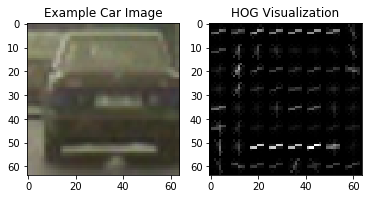

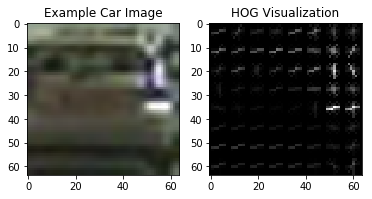

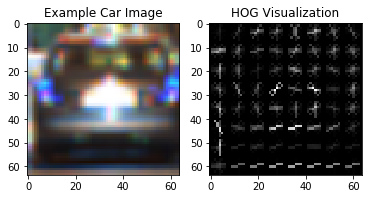

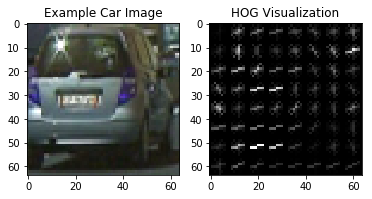

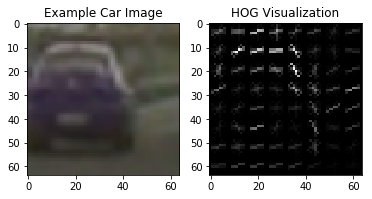

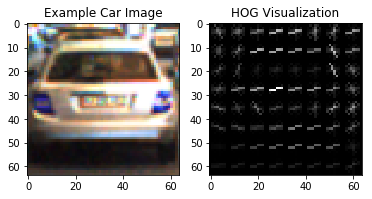

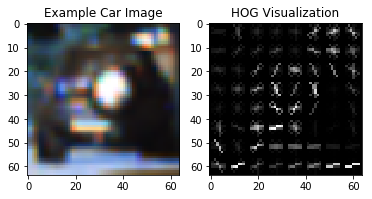

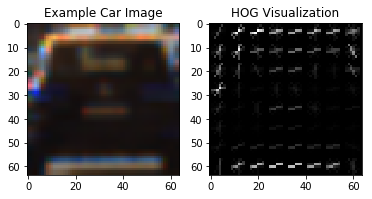

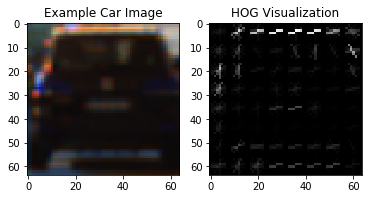

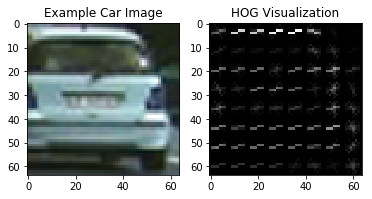

In [13]:
for car in sample_car:
    img = cv2.imread(car)


    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    feature_sample, hog_img = get_hog_features(gray, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        vis=True, feature_vec=True)

    print(len(feature_sample))
    
    # Plot the examples
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(img, cmap='gray')
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(hog_img, cmap='gray')
    plt.title('HOG Visualization')
    
plt.show()

1764
1764
1764
1764
1764
1764
1764
1764
1764
1764


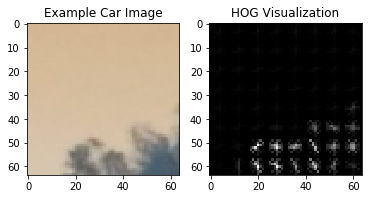

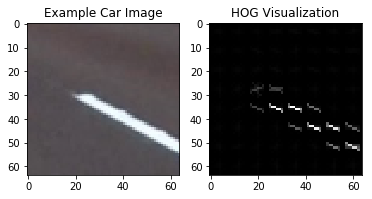

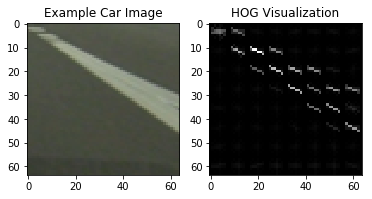

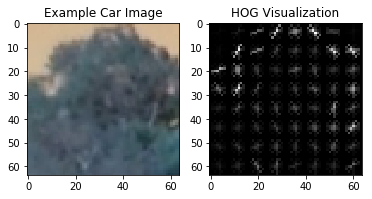

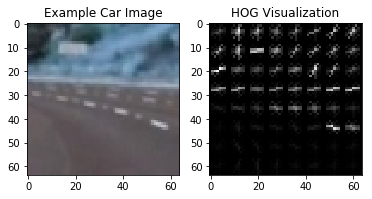

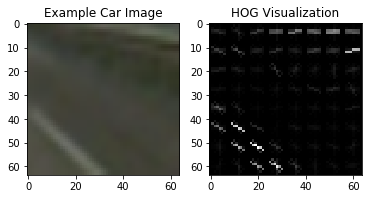

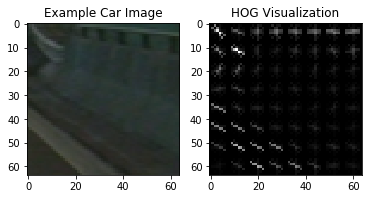

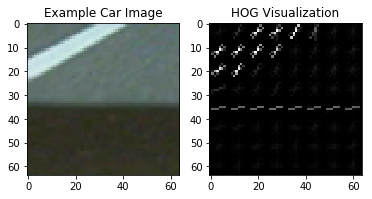

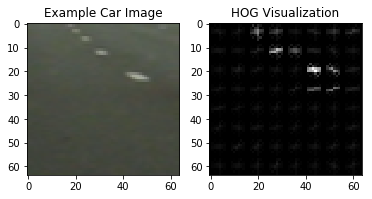

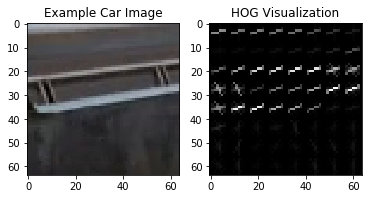

In [14]:
for nocar in sample_notcar:
    img = cv2.imread(nocar)


    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    feature_sample, hog_img = get_hog_features(gray, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        vis=True, feature_vec=True)

    print(len(feature_sample))
    
    # Plot the examples
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(img, cmap='gray')
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(hog_img, cmap='gray')
    plt.title('HOG Visualization')
    
plt.show()

In [15]:
'''
####################### Color Classify #########################
################### now we can draw histogram of each color channel or all channels #####

'''

'\n####################### Color Classify #########################\n################### now we can draw histogram of each color channel or all channels #####\n\n'

In [16]:
'''
Convert image to one-d feature fector (with resize based on bins)--getting super small sample of img
TODO: test if we can get the spatial resolution lower with same accuracy-(have tried 20/20 successfully)
'''
def bin_spatial(img, size=(32, 32)):
    small_img = cv2.resize(img, size)
    features = small_img.ravel()
    return features

'''
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
'''


'\ndef bin_spatial(img, size=(32, 32)):\n    color1 = cv2.resize(img[:,:,0], size).ravel()\n    color2 = cv2.resize(img[:,:,1], size).ravel()\n    color3 = cv2.resize(img[:,:,2], size).ravel()\n    return np.hstack((color1, color2, color3))\n'

In [17]:

'''
Define a function to compute color histogram features 
'''

# here img should be color img !

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

In [18]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # for verify
        print(len(spatial_features))
        
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # for verify
        print(len(hist_features))
        
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # for verify
        print(len(hog_features))
        
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [19]:
'''
mpimg.imread for cv2.COLOR_RGB2 **

cv2.imread for cv2.COLOR_BGR2 **
'''

'\nmpimg.imread for cv2.COLOR_RGB2 **\n\ncv2.imread for cv2.COLOR_BGR2 **\n'

In [20]:

img0 =  mpimg.imread(sample_car[0])



features_img0 = single_img_features(img0, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True)

3072
96
1764


In [21]:
print(features_img0, len(features_img0))

[ 0.32549021  0.33725491  0.35980392 ...,  0.00071983  0.00056907
  0.00080479] 4932


In [22]:
notcar_img0 =  mpimg.imread(sample_notcar[0])



features_notcar_img0 = single_img_features(notcar_img0, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True)

3072
96
1764


In [23]:
'''

now extrace color features for a list of images
'''

'\n\nnow extrace color features for a list of images\n'

In [24]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_color_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        ### only for verify
        print(len(spatial_features))
        
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        ### only for verify
        print(len(hist_features))
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

In [25]:
# return 10 * 4932
features_car =  extract_color_features(sample_car, cspace='HSV', spatial_size=(32, 32),
                        hist_bins=32)

3072
96
3072
96
3072
96
3072
96
3072
96
3072
96
3072
96
3072
96
3072
96
3072
96


In [26]:
features_notcar =  extract_color_features(sample_notcar, cspace='HSV', spatial_size=(32, 32),
                        hist_bins=32)

3072
96
3072
96
3072
96
3072
96
3072
96
3072
96
3072
96
3072
96
3072
96
3072
96


In [27]:
'''

for 3072 small value spatial_features combined with 96 larger value hist_features,

do normalization !!
''' 

'\n\nfor 3072 small value spatial_features combined with 96 larger value hist_features,\n\ndo normalization !!\n'

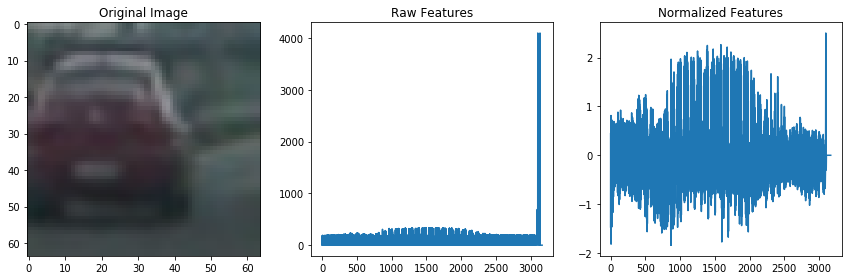

In [28]:
if len(features_car) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((features_car, features_notcar)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(sample_car))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(sample_car[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()

In [29]:
'''

##################### notice:  ###########################

spatial 3072 features can has pixel value of

1) 0 ~1, if mpimg.imread(.png)
2) 0 ~ 255, if cv2.imread(.png) or mpimg.imread(.jpg)
3) 0 ~255, if color space convert through cv2.cvtColor
'''

'\n\n##################### notice:  ###########################\n\nspatial 3072 features can has pixel value of\n\n1) 0 ~1, if mpimg.imread(.png)\n2) 0 ~ 255, if cv2.imread(.png) or mpimg.imread(.jpg)\n3) 0 ~255, if color space convert through cv2.cvtColor\n'

In [30]:
'''

################ combine color + HOG features ###############
'''

'\n\n################ combine color + HOG features ###############\n'

In [31]:

'''
Define a function to extract features from a list of images
Have this function call bin_spatial() and color_hist()
'''
def extract_combo_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for file in imgs:
        file_features = []
        image = cv2.imread(file)

        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else: feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            print(len(hog_features))
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))

    return features

In [32]:
features_car =  extract_combo_features(sample_car, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True)

1764
1764
1764
1764
1764
1764
1764
1764
1764
1764


In [33]:
features_notcar =  extract_combo_features(sample_notcar, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True)

1764
1764
1764
1764
1764
1764
1764
1764
1764
1764


In [34]:
print(len(features_car[0]))

4932


In [35]:
print(len(features_notcar[0]))

4932


StandardScaler(copy=True, with_mean=True, with_std=True)


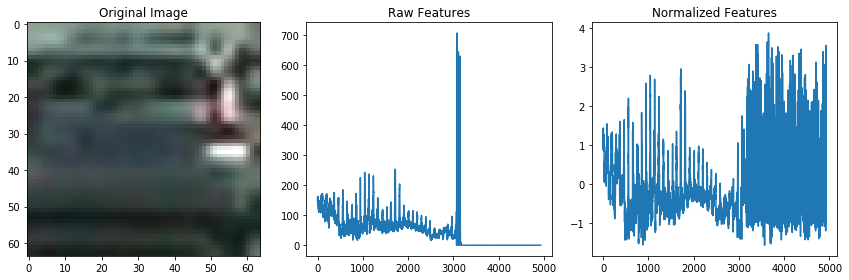

In [36]:
if len(features_car) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((features_car, features_notcar)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    
    print(X_scaler)
    
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(sample_car))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(sample_car[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()


In [37]:
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 5  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 720] # Min and max in y to search in slide_window()

In [38]:
# Parameters below for saving data for future reference
image_file_name = "trainfeature/" + str(color_space) + "_spatial" + str(spatial_size[0]) + str(spatial_size[1]) + "_hbins" + str(hist_bins) + "_TTT_" + "orient" + str(orient) \
                    + "_pixelcell" + str(pix_per_cell) + "_cellblock" \
                    + str(cell_per_block) + "_hogchannel" + str(hog_channel)
                    #+ str(xy_window_size[0]) + str(xy_window_size[1]) + "_olp" \
                    #+ str(xy_overlap_size[0]) + str(xy_overlap_size[1])

image_title = "orient" + str(orient) + str(pix_per_cell) + "ppc" + "_cb" \
                    + str(cell_per_block)
logfilepath = "logs/train_results/result.md"

In [39]:
def normalise(image):
    return (image - image.mean()) / (image.max() - image.min())

In [40]:


# can return visualized result .png for plotting
def extract_features_plot(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True,
                     viz=False, viz_only=False, hog_viz_name="", viz_title="HOG Viz"):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        
        # output feature_image will have pixel-wise value 0 ~ 255
        image = cv2.imread(file)

        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else: 
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
            
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
            
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if viz == True:
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_feature, hog_image = get_hog_features(feature_image[:, :, channel],
                                                                  orient, pix_per_cell, cell_per_block,
                                                                  vis=True, feature_vec=True)
                        hog_features.append(hog_feature)
                    hog_features = np.ravel(hog_features)
                else:
                    hog_features, hog_image = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                               pix_per_cell, cell_per_block, vis=True, feature_vec=True)
                # Plot HOG visualisation

                if viz_only == True:
                    fig = plt.figure()
                    plt.imshow(hog_image)
                    plt.title(viz_title)
                    plt.savefig(hog_viz_name, bbox_inches='tight')

                else:
                    fig = plt.figure()
                    plt.subplot(121)
                    plt.imshow(image)
                    plt.title('Example Image')
                    plt.subplot(122)
                    plt.imshow(hog_image)
                    plt.title('Example HOG viz')
                    plt.savefig(hog_viz_name + "_double", bbox_inches='tight')

            else:
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_feature = get_hog_features(feature_image[:, :, channel],
                                                       orient, pix_per_cell, cell_per_block,
                                                       vis=False, feature_vec=True)
                        hog_features.append(hog_feature)
                    hog_features = np.ravel(hog_features)
                else:
                    hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features




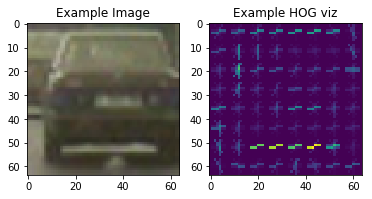

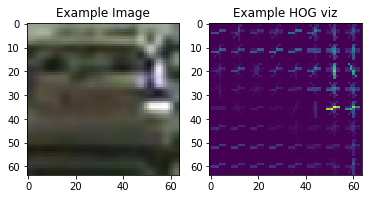

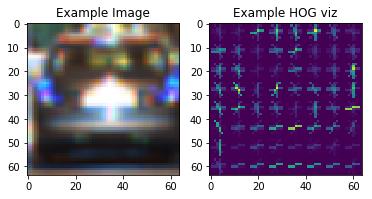

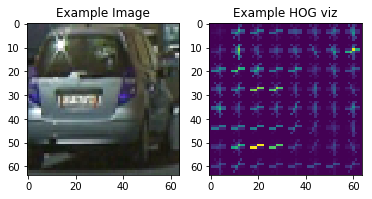

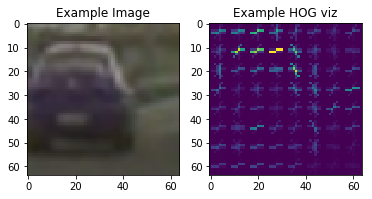

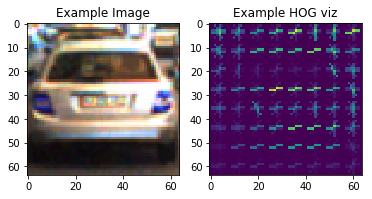

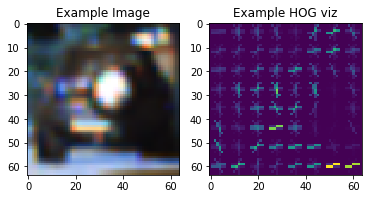

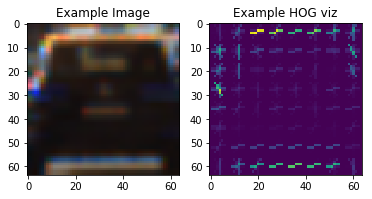

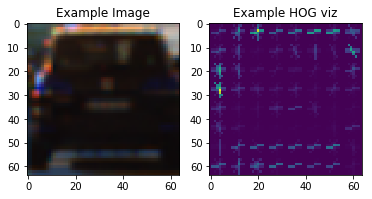

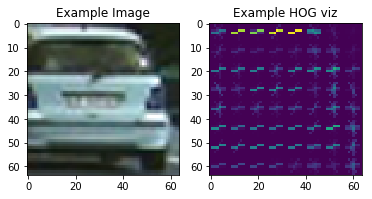

In [41]:
sample_car_features = extract_features_plot(sample_car, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat,
                        viz=True, viz_only=False, viz_title=image_title, hog_viz_name=image_file_name)

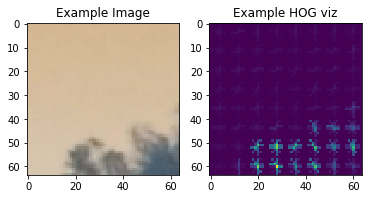

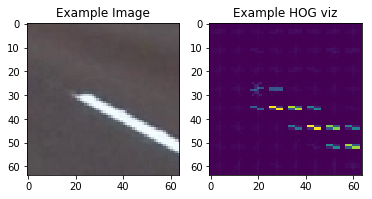

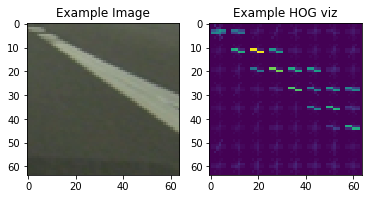

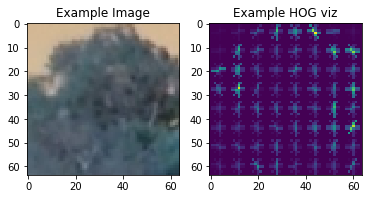

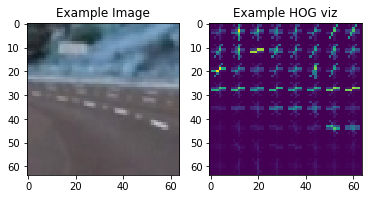

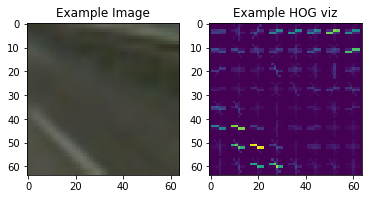

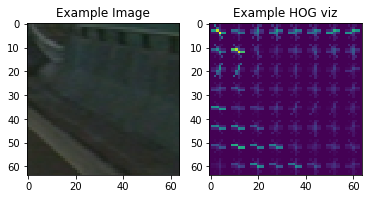

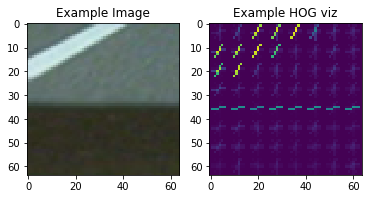

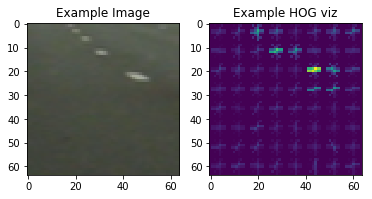

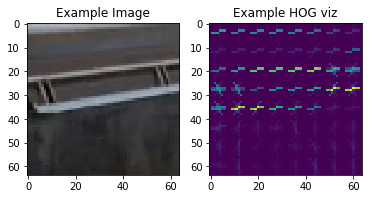

In [42]:
sample_notcar_features = extract_features_plot(sample_notcar, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat,
                        viz=True, viz_only=False, viz_title=image_title, hog_viz_name=image_file_name)

In [43]:
'''
########### train step 1: test differenct color features to train a SVC #####################

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV
spatial_size = (4,4)(8,8)(16, 16)(32,32) # Spatial binning dimensions
hist_bins = 8,16,24,32,64    # Number of histogram bins

TO see: depending on the test accuracy, which color parameter to choose ?
'''

"\n########### train step 1: test differenct color features to train a SVC #####################\n\ncolor_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV\nspatial_size = (4,4)(8,8)(16, 16)(32,32) # Spatial binning dimensions\nhist_bins = 8,16,24,32,64    # Number of histogram bins\n\nTO see: depending on the test accuracy, which color parameter to choose ?\n"

In [45]:
from sklearn.utils import shuffle

orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_feat = True
hist_feat = True
hog_feat = False

for color_space in [ 'YCrCb', 'RGB', 'HSV', 'LUV', 'HLS', 'YUV'] :
    for spatial_size in [ (4,4), (8,8), (16,16), (32,32)] :
        for hist_bins in [8, 16, 24, 32] :
            car_features = extract_features_plot(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat= hog_feat)
            notcar_features = extract_features_plot(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

            X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
            # Fit a per-column scaler
            X_scaler = StandardScaler().fit(X)
            # Apply the scaler to X
            scaled_X = X_scaler.transform(X)

            # Normalise input
            X = normalise(X)

            # Define the labels vector
            y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

            # Split up data into randomized training and test sets
            X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)

            print('Using:',color_space,'color_space',spatial_size, 'spatial_size', hist_bins ,'hist_bins')

            ''' train a linear SVC '''
            
            X_train, y_train = shuffle(X_train, y_train)
            
            print(len(y_train))
            train_size = 500
            
            X_train_mini = X_train[0:train_size]
            y_train_mini = y_train[0:train_size]

            # rbf kernel takes 3 * training time and less accuracy, linear is fine enough to use:
            #for kernel in ['linear', 'rbf']:
            for kernel in ['linear']:
    
                svc = SVC(kernel = kernel, C=1, gamma =1)
                # Check the training time for the SVC
                t=time.time()
                svc.fit(X_train_mini, y_train_mini)
                t2 = time.time()
                training_time = round(t2-t, 4)
                
                print("\n\n\n")
                      
                print(training_time, 'Seconds to train SVC...')
                # Check the score of the SVC
                svc_score = round(svc.score(X_test, y_test), 8)
                print('Test Accuracy of SVC = ', svc_score)
                # Check the prediction time for a single sample
                t=time.time()

                # Log training parameters and results

                with open(logfilepath, "a") as f:
                    
                    f.write("\nParameters:")
                    f.write("\nkernel: " + str(kernel))
                    f.write("\ncolor_space: " + str(color_space))
                    f.write("\norient: " + str(orient))
                    f.write("\npix_per_cell: " + str(pix_per_cell))
                    f.write("\ncell_per_block: " + str(cell_per_block))
                    f.write("\nhog_channel: " + str(hog_channel))
                    f.write("\nspatial_size: " + str(spatial_size))
                    f.write("\nhist_bins: " + str(hist_bins))
                    f.write("\nspatial_feat: " + str(spatial_feat))
                    f.write("\nhist_feat: " + str(hist_feat))
                    f.write("\nhog_feat: " + str(hog_feat))
                    f.write('\nFeature vector length:' + str(len(X_train[0])))
                    f.write("\n" + str(training_time) + 'Seconds to train SVC...')
                    f.write('\nTest Accuracy of SVC = ' + str(svc_score))

                print("\nParameters:")
                print("kernel: ", kernel)
                print("color_space: ", color_space)
                print("orient: ", orient)
                print("pix_per_cell: ", pix_per_cell)
                print("cell_per_block: ", cell_per_block)
                print("hog_channel: ", hog_channel)
                print("spatial_size: ", spatial_size)
                print("hist_bins: ", hist_bins)
                print("spatial_feat: ", spatial_feat)
                print("hist_feat: ", hist_feat)
                print("hog_feat: ", hog_feat)
                print("Feature vector length: ", len(X_train[0]) )

print("===================== color feature training successfully done ! ======================")

KeyboardInterrupt: 

In [ ]:
'''
########### train step 2: test differenct hog features to train a SVC #####################

with selected color features from train step 1,

color_space = 'YCrCb'  RGB, HSV, LUV, HLS, YUV
orient = [4, 5, 6, 7, 8, 9, 10]
pix_per_cell = [4, 6, 8, 12, 16 ]
cell_per_block =  [2, 4, 6, 8, 10] 
hog_channel = [0, 1, 2, "ALL"]

also， LinearSVC is faster than linear kernel SVC than rbf kernel SVC, so switch to train LinearSVC

TO see: depending on the test accuracy, which hog parameter to choose ?

'''

In [51]:
hist_bins = 32
spatial_size = (32,32)

spatial_feat = False
hist_feat = False
hog_feat = True

for color_space in ['YCrCb', 'RGB', 'HSV', 'LUV', 'HLS', 'YUV' ] :
    for orient in [4, 5, 6, 7, 8, 9, 10] :
        for pix_per_cell in [4, 8, 12, 16 ] :
            for cell_per_block in [2, 4, 8] :
                for hog_channel in [0, "ALL"] :
                    car_features = extract_features_plot(cars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat= hog_feat,
                                viz=False)
                    notcar_features = extract_features_plot(notcars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat,
                                viz=False)

                    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
                    # Fit a per-column scaler
                    X_scaler = StandardScaler().fit(X)
                    # Apply the scaler to X
                    scaled_X = X_scaler.transform(X)

                    # Normalise input
                    X = normalise(X)

                    # Define the labels vector
                    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
                    
                    # Split up data into randomized training and test sets
                    rand_state = np.random.randint(0, 100)

                    # Split up data into randomized training and test sets
                    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)


                    ''' train a linear SVC '''
                    
                    X_train, y_train = shuffle(X_train, y_train)
                    
                    print(len(y_train))
                    train_size = 500
                    
                    X_train_mini = X_train[0:train_size]
                    y_train_mini = y_train[0:train_size]

                    # rbf kernel takes 3 * training time and less accuracy, linear is fine enough to use:
                    #for kernel in ['linear', 'rbf']:
                    #for kernel in ['linear']:
                    
                    # svc = LinearSVC() is faster than linear kernel
                    #svc = SVC(kernel = kernel, C=1, gamma =1)
                    svc = LinearSVC()
                    
                    # Check the training time for the SVC
                    t=time.time()
                    svc.fit(X_train_mini, y_train_mini)
                    t2 = time.time()
                    training_time = round(t2-t, 4)
                    
                    print("\n\n\n")
                    
                    print(training_time, 'Seconds to train SVC...')
                    # Check the score of the SVC
                    svc_score = round(svc.score(X_test, y_test), 8)
                    print('Test Accuracy of SVC = ', svc_score)
                    # Check the prediction time for a single sample
                    t=time.time()
                    
                    print("\nParameters:")
                    print("color_space: ", color_space)
                    print("orient: ", orient)
                    print("pix_per_cell: ", pix_per_cell)
                    print("cell_per_block: ", cell_per_block)
                    print("hog_channel: ", hog_channel)
                    print("spatial_size: ", spatial_size)
                    print("hist_bins: ", hist_bins)
                    print("spatial_feat: ", spatial_feat)
                    print("hist_feat: ", hist_feat)
                    print("hog_feat: ", hog_feat)
                    print("Feature vector length: ", len(X_train[0]) )
                    
                    # Log training parameters and results

                    with open(logfilepath, "a") as f:
                        
                        f.write("\nParameters:")
                        f.write("\ncolor_space: " + str(color_space))
                        f.write("\norient: " + str(orient))
                        f.write("\npix_per_cell: " + str(pix_per_cell))
                        f.write("\ncell_per_block: " + str(cell_per_block))
                        f.write("\nhog_channel: " + str(hog_channel))
                        f.write("\nspatial_size: " + str(spatial_size))
                        f.write("\nhist_bins: " + str(hist_bins))
                        f.write("\nspatial_feat: " + str(spatial_feat))
                        f.write("\nhist_feat: " + str(hist_feat))
                        f.write("\nhog_feat: " + str(hog_feat))
                        f.write('\nFeature vector length:' + str(len(X_train[0])))
                        f.write("\n" + str(training_time) + 'Seconds to train SVC...')
                        f.write('\nTest Accuracy of SVC = ' + str(svc_score))
                        f.write("\n\n\n")
                        
print("===================== hog feature training successfully done ! ======================")

14208




2.883 Seconds to train SVC...
Test Accuracy of SVC =  0.90259009

Parameters:
color_space:  YCrCb
orient:  4
pix_per_cell:  4
cell_per_block:  2
hog_channel:  0
spatial_size:  (32, 32)
hist_bins:  32
spatial_feat:  False
hist_feat:  False
hog_feat:  True
Feature vector length:  3600
14208




0.2721 Seconds to train SVC...
Test Accuracy of SVC =  0.94932432

Parameters:
color_space:  YCrCb
orient:  4
pix_per_cell:  4
cell_per_block:  2
hog_channel:  ALL
spatial_size:  (32, 32)
hist_bins:  32
spatial_feat:  False
hist_feat:  False
hog_feat:  True
Feature vector length:  10800


MemoryError: 

In [44]:
hist_bins = 32
spatial_size = (32,32)

color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

spatial_feat = True
hist_feat = True
hog_feat = True

car_features = extract_features_plot(cars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat= hog_feat,
                                viz=False)
notcar_features = extract_features_plot(notcars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat,
                                viz=False)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
                    # Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
                    # Apply the scaler to X
scaled_X = X_scaler.transform(X)

                    # Normalise input
X = normalise(X)

                    # Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
                    
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)


''' train a linear SVC '''

X_train, y_train = shuffle(X_train, y_train)

print(len(y_train))
train_size = 500

#X_train_mini = X_train[0:train_size]
#y_train_mini = y_train[0:train_size]

X_train_mini = X_train

y_train_mini = y_train

# rbf kernel takes 3 * training time and less accuracy, linear is fine enough to use:
#for kernel in ['linear', 'rbf']:
#for kernel in ['linear']:

# svc = LinearSVC() is faster than linear kernel
#svc = SVC(kernel = kernel, C=1, gamma =1)
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train_mini, y_train_mini)
t2 = time.time()
training_time = round(t2-t, 4)

print("\n\n\n")

print(training_time, 'Seconds to train SVC...')
# Check the score of the SVC
svc_score = round(svc.score(X_test, y_test), 8)
print('Test Accuracy of SVC = ', svc_score)
# Check the prediction time for a single sample
t=time.time()

print("\nParameters:")
print("color_space: ", color_space)
print("orient: ", orient)
print("pix_per_cell: ", pix_per_cell)
print("cell_per_block: ", cell_per_block)
print("hog_channel: ", hog_channel)
print("spatial_size: ", spatial_size)
print("hist_bins: ", hist_bins)
print("spatial_feat: ", spatial_feat)
print("hist_feat: ", hist_feat)
print("hog_feat: ", hog_feat)
print("Feature vector length: ", len(X_train[0]) )

14208




17.7143 Seconds to train SVC...
Test Accuracy of SVC =  0.99380631

Parameters:
color_space:  YCrCb
orient:  9
pix_per_cell:  8
cell_per_block:  2
hog_channel:  ALL
spatial_size:  (32, 32)
hist_bins:  32
spatial_feat:  True
hist_feat:  True
hog_feat:  True
Feature vector length:  8460


In [47]:
hist_bins = 32
spatial_size = (32,32)

color_space = 'YUV' 
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

spatial_feat = True
hist_feat = True
hog_feat = True

car_features = extract_features_plot(cars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat= hog_feat,
                                viz=False)
notcar_features = extract_features_plot(notcars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat,
                                viz=False)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
                    # Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
                    # Apply the scaler to X
scaled_X = X_scaler.transform(X)

                    # Normalise input
X = normalise(X)

                    # Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
                    
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)


''' train a linear SVC '''

X_train, y_train = shuffle(X_train, y_train)

print(len(y_train))
train_size = 500

#X_train_mini = X_train[0:train_size]
#y_train_mini = y_train[0:train_size]

X_train_mini = X_train

y_train_mini = y_train

# rbf kernel takes 3 * training time and less accuracy, linear is fine enough to use:
#for kernel in ['linear', 'rbf']:
#for kernel in ['linear']:

# svc = LinearSVC() is faster than linear kernel
#svc = SVC(kernel = kernel, C=1, gamma =1)
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train_mini, y_train_mini)
t2 = time.time()
training_time = round(t2-t, 4)

print("\n\n\n")

print(training_time, 'Seconds to train SVC...')
# Check the score of the SVC
svc_score = round(svc.score(X_test, y_test), 8)
print('Test Accuracy of SVC = ', svc_score)
# Check the prediction time for a single sample
t=time.time()

print("\nParameters:")
print("color_space: ", color_space)
print("orient: ", orient)
print("pix_per_cell: ", pix_per_cell)
print("cell_per_block: ", cell_per_block)
print("hog_channel: ", hog_channel)
print("spatial_size: ", spatial_size)
print("hist_bins: ", hist_bins)
print("spatial_feat: ", spatial_feat)
print("hist_feat: ", hist_feat)
print("hog_feat: ", hog_feat)
print("Feature vector length: ", len(X_train[0]) )

14208




4.6735 Seconds to train SVC...
Test Accuracy of SVC =  0.99268018

Parameters:
color_space:  YUV
orient:  9
pix_per_cell:  8
cell_per_block:  2
hog_channel:  ALL
spatial_size:  (32, 32)
hist_bins:  32
spatial_feat:  True
hist_feat:  True
hog_feat:  True
Feature vector length:  8460


In [48]:
hist_bins = 32
spatial_size = (32,32)

color_space = 'RGB'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

spatial_feat = True
hist_feat = True
hog_feat = True

car_features = extract_features_plot(cars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat= hog_feat,
                                viz=False)
notcar_features = extract_features_plot(notcars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat,
                                viz=False)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
                    # Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
                    # Apply the scaler to X
scaled_X = X_scaler.transform(X)

                    # Normalise input
X = normalise(X)

                    # Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
                    
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)


''' train a linear SVC '''

X_train, y_train = shuffle(X_train, y_train)

print(len(y_train))
train_size = 500

#X_train_mini = X_train[0:train_size]
#y_train_mini = y_train[0:train_size]

X_train_mini = X_train

y_train_mini = y_train

# rbf kernel takes 3 * training time and less accuracy, linear is fine enough to use:
#for kernel in ['linear', 'rbf']:
#for kernel in ['linear']:

# svc = LinearSVC() is faster than linear kernel
#svc = SVC(kernel = kernel, C=1, gamma =1)
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train_mini, y_train_mini)
t2 = time.time()
training_time = round(t2-t, 4)

print("\n\n\n")

print(training_time, 'Seconds to train SVC...')
# Check the score of the SVC
svc_score = round(svc.score(X_test, y_test), 8)
print('Test Accuracy of SVC = ', svc_score)
# Check the prediction time for a single sample
t=time.time()

print("\nParameters:")
print("color_space: ", color_space)
print("orient: ", orient)
print("pix_per_cell: ", pix_per_cell)
print("cell_per_block: ", cell_per_block)
print("hog_channel: ", hog_channel)
print("spatial_size: ", spatial_size)
print("hist_bins: ", hist_bins)
print("spatial_feat: ", spatial_feat)
print("hist_feat: ", hist_feat)
print("hog_feat: ", hog_feat)
print("Feature vector length: ", len(X_train[0]) )

14208




31.8234 Seconds to train SVC...
Test Accuracy of SVC =  0.98198198

Parameters:
color_space:  RGB
orient:  9
pix_per_cell:  8
cell_per_block:  2
hog_channel:  ALL
spatial_size:  (32, 32)
hist_bins:  32
spatial_feat:  True
hist_feat:  True
hog_feat:  True
Feature vector length:  8460


In [49]:
hist_bins = 32
spatial_size = (32,32)

color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

spatial_feat = False
hist_feat = False
hog_feat = True

car_features = extract_features_plot(cars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat= hog_feat,
                                viz=False)
notcar_features = extract_features_plot(notcars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat,
                                viz=False)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
                    # Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
                    # Apply the scaler to X
scaled_X = X_scaler.transform(X)

                    # Normalise input
X = normalise(X)

                    # Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
                    
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)


''' train a linear SVC '''

X_train, y_train = shuffle(X_train, y_train)

print(len(y_train))
train_size = 500

#X_train_mini = X_train[0:train_size]
#y_train_mini = y_train[0:train_size]

X_train_mini = X_train

y_train_mini = y_train

# rbf kernel takes 3 * training time and less accuracy, linear is fine enough to use:
#for kernel in ['linear', 'rbf']:
#for kernel in ['linear']:

# svc = LinearSVC() is faster than linear kernel
#svc = SVC(kernel = kernel, C=1, gamma =1)
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train_mini, y_train_mini)
t2 = time.time()
training_time = round(t2-t, 4)

print("\n\n\n")

print(training_time, 'Seconds to train SVC...')
# Check the score of the SVC
svc_score = round(svc.score(X_test, y_test), 8)
print('Test Accuracy of SVC = ', svc_score)
# Check the prediction time for a single sample
t=time.time()

print("\nParameters:")
print("color_space: ", color_space)
print("orient: ", orient)
print("pix_per_cell: ", pix_per_cell)
print("cell_per_block: ", cell_per_block)
print("hog_channel: ", hog_channel)
print("spatial_size: ", spatial_size)
print("hist_bins: ", hist_bins)
print("spatial_feat: ", spatial_feat)
print("hist_feat: ", hist_feat)
print("hog_feat: ", hog_feat)
print("Feature vector length: ", len(X_train[0]) )

14208




3.0127 Seconds to train SVC...
Test Accuracy of SVC =  0.98958333

Parameters:
color_space:  YCrCb
orient:  9
pix_per_cell:  8
cell_per_block:  2
hog_channel:  ALL
spatial_size:  (32, 32)
hist_bins:  32
spatial_feat:  False
hist_feat:  False
hog_feat:  True
Feature vector length:  5292


In [50]:
hist_bins = 32
spatial_size = (32,32)

color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 1 #'ALL'

spatial_feat = True
hist_feat = True
hog_feat = True

car_features = extract_features_plot(cars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat= hog_feat,
                                viz=False)
notcar_features = extract_features_plot(notcars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat,
                                viz=False)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
                    # Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
                    # Apply the scaler to X
scaled_X = X_scaler.transform(X)

                    # Normalise input
X = normalise(X)

                    # Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
                    
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)


''' train a linear SVC '''

X_train, y_train = shuffle(X_train, y_train)

print(len(y_train))
train_size = 500

#X_train_mini = X_train[0:train_size]
#y_train_mini = y_train[0:train_size]

X_train_mini = X_train

y_train_mini = y_train

# rbf kernel takes 3 * training time and less accuracy, linear is fine enough to use:
#for kernel in ['linear', 'rbf']:
#for kernel in ['linear']:

# svc = LinearSVC() is faster than linear kernel
#svc = SVC(kernel = kernel, C=1, gamma =1)
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train_mini, y_train_mini)
t2 = time.time()
training_time = round(t2-t, 4)

print("\n\n\n")

print(training_time, 'Seconds to train SVC...')
# Check the score of the SVC
svc_score = round(svc.score(X_test, y_test), 8)
print('Test Accuracy of SVC = ', svc_score)
# Check the prediction time for a single sample
t=time.time()

print("\nParameters:")
print("color_space: ", color_space)
print("orient: ", orient)
print("pix_per_cell: ", pix_per_cell)
print("cell_per_block: ", cell_per_block)
print("hog_channel: ", hog_channel)
print("spatial_size: ", spatial_size)
print("hist_bins: ", hist_bins)
print("spatial_feat: ", spatial_feat)
print("hist_feat: ", hist_feat)
print("hog_feat: ", hog_feat)
print("Feature vector length: ", len(X_train[0]) )

14208




17.8318 Seconds to train SVC...
Test Accuracy of SVC =  0.97494369

Parameters:
color_space:  YCrCb
orient:  9
pix_per_cell:  8
cell_per_block:  2
hog_channel:  1
spatial_size:  (32, 32)
hist_bins:  32
spatial_feat:  True
hist_feat:  True
hog_feat:  True
Feature vector length:  4932


In [51]:
hist_bins = 32
spatial_size = (32,32)

color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 8
hog_channel = 'ALL'

spatial_feat = True
hist_feat = True
hog_feat = True

car_features = extract_features_plot(cars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat= hog_feat,
                                viz=False)
notcar_features = extract_features_plot(notcars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat,
                                viz=False)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
                    # Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
                    # Apply the scaler to X
scaled_X = X_scaler.transform(X)

                    # Normalise input
X = normalise(X)

                    # Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
                    
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)


''' train a linear SVC '''

X_train, y_train = shuffle(X_train, y_train)

print(len(y_train))
train_size = 500

#X_train_mini = X_train[0:train_size]
#y_train_mini = y_train[0:train_size]

X_train_mini = X_train

y_train_mini = y_train

# rbf kernel takes 3 * training time and less accuracy, linear is fine enough to use:
#for kernel in ['linear', 'rbf']:
#for kernel in ['linear']:

# svc = LinearSVC() is faster than linear kernel
#svc = SVC(kernel = kernel, C=1, gamma =1)
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train_mini, y_train_mini)
t2 = time.time()
training_time = round(t2-t, 4)

print("\n\n\n")

print(training_time, 'Seconds to train SVC...')
# Check the score of the SVC
svc_score = round(svc.score(X_test, y_test), 8)
print('Test Accuracy of SVC = ', svc_score)
# Check the prediction time for a single sample
t=time.time()

print("\nParameters:")
print("color_space: ", color_space)
print("orient: ", orient)
print("pix_per_cell: ", pix_per_cell)
print("cell_per_block: ", cell_per_block)
print("hog_channel: ", hog_channel)
print("spatial_size: ", spatial_size)
print("hist_bins: ", hist_bins)
print("spatial_feat: ", spatial_feat)
print("hist_feat: ", hist_feat)
print("hog_feat: ", hog_feat)
print("Feature vector length: ", len(X_train[0]) )

14208




14.1049 Seconds to train SVC...
Test Accuracy of SVC =  0.99042793

Parameters:
color_space:  YCrCb
orient:  9
pix_per_cell:  8
cell_per_block:  8
hog_channel:  ALL
spatial_size:  (32, 32)
hist_bins:  32
spatial_feat:  True
hist_feat:  True
hog_feat:  True
Feature vector length:  4896


In [44]:
hist_bins = 32
spatial_size = (32,32)

color_space = 'YCrCb'
orient = 5
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

spatial_feat = True
hist_feat = True
hog_feat = True

car_features = extract_features_plot(cars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat= hog_feat,
                                viz=False)
notcar_features = extract_features_plot(notcars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat,
                                viz=False)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
                    # Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
                    # Apply the scaler to X
scaled_X = X_scaler.transform(X)

                    # Normalise input
X = normalise(X)

                    # Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
                    
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)


''' train a linear SVC '''

X_train, y_train = shuffle(X_train, y_train)

print(len(y_train))
train_size = 500

#X_train_mini = X_train[0:train_size]
#y_train_mini = y_train[0:train_size]

X_train_mini = X_train

y_train_mini = y_train

# rbf kernel takes 3 * training time and less accuracy, linear is fine enough to use:
#for kernel in ['linear', 'rbf']:
#for kernel in ['linear']:

# svc = LinearSVC() is faster than linear kernel
#svc = SVC(kernel = kernel, C=1, gamma =1)
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train_mini, y_train_mini)
t2 = time.time()
training_time = round(t2-t, 4)

print("\n\n\n")

print(training_time, 'Seconds to train SVC...')
# Check the score of the SVC
svc_score = round(svc.score(X_test, y_test), 8)
print('Test Accuracy of SVC = ', svc_score)
# Check the prediction time for a single sample
t=time.time()

print("\nParameters:")
print("color_space: ", color_space)
print("orient: ", orient)
print("pix_per_cell: ", pix_per_cell)
print("cell_per_block: ", cell_per_block)
print("hog_channel: ", hog_channel)
print("spatial_size: ", spatial_size)
print("hist_bins: ", hist_bins)
print("spatial_feat: ", spatial_feat)
print("hist_feat: ", hist_feat)
print("hog_feat: ", hog_feat)
print("Feature vector length: ", len(X_train[0]) )

14208




5.7216 Seconds to train SVC...
Test Accuracy of SVC =  0.98902027

Parameters:
color_space:  YCrCb
orient:  5
pix_per_cell:  8
cell_per_block:  2
hog_channel:  ALL
spatial_size:  (32, 32)
hist_bins:  32
spatial_feat:  True
hist_feat:  True
hog_feat:  True
Feature vector length:  6108


In [45]:
hist_bins = 32
spatial_size = (32,32)

color_space = 'YCrCb'
orient = 9
pix_per_cell = 4
cell_per_block = 2
hog_channel = 'ALL'

spatial_feat = True
hist_feat = True
hog_feat = True

car_features = extract_features_plot(cars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat= hog_feat,
                                viz=False)
notcar_features = extract_features_plot(notcars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat,
                                viz=False)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
                    # Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
                    # Apply the scaler to X
scaled_X = X_scaler.transform(X)

                    # Normalise input
X = normalise(X)

                    # Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
                    
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)


''' train a linear SVC '''

X_train, y_train = shuffle(X_train, y_train)

print(len(y_train))
train_size = 500

#X_train_mini = X_train[0:train_size]
#y_train_mini = y_train[0:train_size]

X_train_mini = X_train

y_train_mini = y_train

# rbf kernel takes 3 * training time and less accuracy, linear is fine enough to use:
#for kernel in ['linear', 'rbf']:
#for kernel in ['linear']:

# svc = LinearSVC() is faster than linear kernel
#svc = SVC(kernel = kernel, C=1, gamma =1)
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train_mini, y_train_mini)
t2 = time.time()
training_time = round(t2-t, 4)

print("\n\n\n")

print(training_time, 'Seconds to train SVC...')
# Check the score of the SVC
svc_score = round(svc.score(X_test, y_test), 8)
print('Test Accuracy of SVC = ', svc_score)
# Check the prediction time for a single sample
t=time.time()

print("\nParameters:")
print("color_space: ", color_space)
print("orient: ", orient)
print("pix_per_cell: ", pix_per_cell)
print("cell_per_block: ", cell_per_block)
print("hog_channel: ", hog_channel)
print("spatial_size: ", spatial_size)
print("hist_bins: ", hist_bins)
print("spatial_feat: ", spatial_feat)
print("hist_feat: ", hist_feat)
print("hog_feat: ", hog_feat)
print("Feature vector length: ", len(X_train[0]) )

MemoryError: 

In [ ]:
"""
Conclution about color + HOG feature parameter choice:

total trained with : 14208


17.7143 Seconds to train SVC...
Test Accuracy of SVC =  0.99380631

Parameters:
color_space:  YCrCb
orient:  9
pix_per_cell:  8
cell_per_block:  2
hog_channel:  ALL
spatial_size:  (32, 32)
hist_bins:  32
spatial_feat:  True
hist_feat:  True
hog_feat:  True
Feature vector length:  8460 len(X_train[0])

1, color space YCrCb is a little better than others
2, hist, spatial features play not much effort, with only HOG is only little worse than combine all of them
3, all hog channels are better than 1 channel, because more features are brought in
4, in HOG parameters, cell per block 8 is worse than 2
5, in HOG parameters, pix_per_cell 4  worse than  8 
6, n HOG parameters, orient 5 worse than 9
7, finally, I don't have all day time to for loop all possiblities, besides this for loop leads to 
memory error on my AWS instance

"""

In [ ]:
'''

############# sliding window implementation #############################

instead of scaning list of windows from original lane picture, and treat each window-size image 
and extract features and use classfier to predict,

we jump to enhanced way:
Hog Sub-sampling Window Search


1, The find_cars only has to extract hog features once and
then can be sub-sampled to get all of its overlaying windows;

x start, stop, y start, stop are chosen to cover bottowm part

2, Each window is defined by a scaling factor 
where a scale of 1 would result in a window that's 8 x 8 cells 
then the overlap of each window is in terms of the cell distance.
This means that a cells_per_step = 2 would result in a search window overlap of 75%.

we can extrace spatial and hist features on each window-size image, but only once for hog !

instead of overlapping factor, we define anyway 64 as window sampling rate to scan the whole region of interest.

3, Its possible to run this same function multiple times 
for different scale values to generate multiple-scaled search windows.

scale = 0.5 leads to too long calucation time and too small windows, 
can't even wrap the whole car!

scale 2 or 1.5 can be chosen

############ reduce false positive implementation #############################

4, add heatmap to reduce false positive



'''

In [121]:
"""

###################### reduce false positive and redudant boxes ####################

use heatmap to reduce false positive

"""

'\n\n###################### reduce false positive ####################\n\nuse heatmap to reduce false positive\n\n'

In [127]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [128]:
from scipy.ndimage.measurements import label

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [181]:

def find_cars(img,scale):
#def find_cars(img, xstart, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    draw_img = np.copy(img)
    
    """
    I trained images wiht 0 ~ 255  in extract_features_plot
    """
    #img = img.astype(np.float32)/255
    
    t = time.time()
    heatmap = np.zeros_like(img[:,:,0])
    #count = 0
    
    img_tosearch = img[ystart:ystop,xstart:,:]
    
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb);
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    #plt.imshow(ctrans_tosearch)
    #plt.show()
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps based on length of image / pix per cell
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    #window_list = []

    # move through each block, extracting hog features that apply
    for xb in range(nxsteps):
        for yb in range(nysteps):
            #count += 1
            
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            #test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))
            
            # if spatial and hist_bins set to true, need to hstack those features
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            #when predict a car, draw it and add bounding box to list
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox = ((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
                #window_list.append(bbox)
                # window_list.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))

                # reduce false positive , use heatmap !!
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
                
    #print(time.time()-t, 'seconds to run, total windows = ', count)
    
    #plt.imshow(heatmap)
    #plt.show()
    
    #return window_list
    # to visualize, return draw_img as well
    #return draw_img, window_list
    return draw_img, heatmap

In [182]:
# 0 ~ 255
img = mpimg.imread('test_images/test1.jpg')

In [183]:
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32, 32)
hist_bins = 32

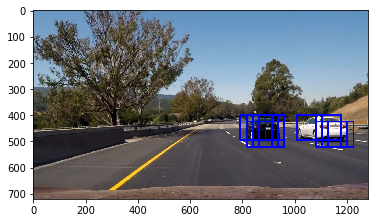

In [195]:
ystart = 400
ystop = 656
xstart = 0 # 600 for only right side cars

scale = 1.5  # 12 windows
#scale = 1  # 20 windows
#scale = 0.5 
#scale = 2  # 5 windows

out_img, heat_map = find_cars(img, scale)


plt.imshow(out_img)



    
# Apply threshold to help remove false positives
threshold_heat_map = apply_threshold(heat_map,4)
#heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
threshold_heat_map = np.clip(threshold_heat_map, 0, 255)

# Find final boxes from heatmap using label function
labels = label(threshold_heat_map)
draw_img = draw_labeled_bboxes(np.copy(out_img), labels)



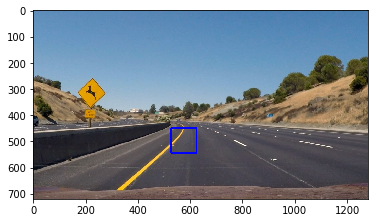

In [196]:
img = mpimg.imread('test_images/test2.jpg')

scale = 1.5  # 1 windows
#scale = 1  # 1 windows
#scale = 0.5 #1 window
#scale = 2  # 0 windows   : the only correct result that no car found !!

out_img, heat_map = find_cars(img, scale)


plt.imshow(out_img)

# Apply threshold to help remove false positives
threshold_heat_map = apply_threshold(heat_map,4)
#heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
threshold_heat_map = np.clip(threshold_heat_map, 0, 255)

# Find final boxes from heatmap using label function
labels = label(threshold_heat_map)
draw_img = draw_labeled_bboxes(np.copy(out_img), labels)

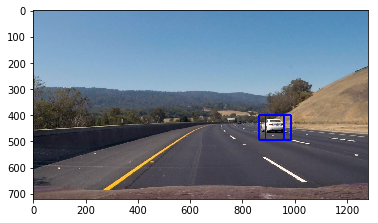

In [197]:
img = mpimg.imread('test_images/test3.jpg')

scale = 1.5  # 2 windows
#scale = 1  # 3 windows
#scale = 0.5 #1
#scale = 2  # 0 windows   : wrong

out_img, heat_map = find_cars(img, scale)


plt.imshow(out_img)

# Apply threshold to help remove false positives
threshold_heat_map = apply_threshold(heat_map,4)
#heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
threshold_heat_map = np.clip(threshold_heat_map, 0, 255)

# Find final boxes from heatmap using label function
labels = label(threshold_heat_map)
draw_img = draw_labeled_bboxes(np.copy(out_img), labels)

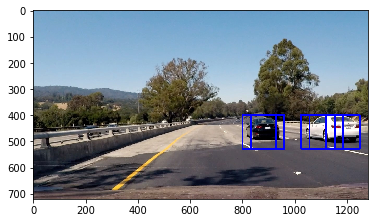

In [198]:
img = mpimg.imread('test_images/test4.jpg')


#scale = 1.5  # 10 windows
#scale = 1  # 13 windows
#scale = 0.5 # 14
scale = 2  # 5 windows   

out_img, heat_map = find_cars(img, scale)


plt.imshow(out_img)

# Apply threshold to help remove false positives
threshold_heat_map = apply_threshold(heat_map,4)
#heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
threshold_heat_map = np.clip(threshold_heat_map, 0, 255)

# Find final boxes from heatmap using label function
labels = label(threshold_heat_map)
draw_img = draw_labeled_bboxes(np.copy(out_img), labels)

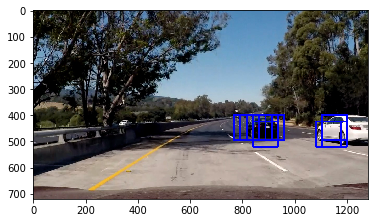

In [199]:
img = mpimg.imread('test_images/test5.jpg')

scale = 1.5  # 9 windows
#scale = 1  # 12 windows

#scale = 2  # 4 windows 


out_img, heat_map = find_cars(img, scale)


plt.imshow(out_img)

# Apply threshold to help remove false positives
threshold_heat_map = apply_threshold(heat_map,4)
#heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
threshold_heat_map = np.clip(threshold_heat_map, 0, 255)

# Find final boxes from heatmap using label function
labels = label(threshold_heat_map)
draw_img = draw_labeled_bboxes(np.copy(out_img), labels)

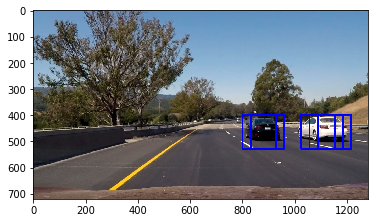

In [200]:
img = mpimg.imread('test_images/test6.jpg')

#scale = 1.5  # 12 windows
#scale = 1  # 20 windows

scale = 2  # 5 windows 

out_img, heat_map = find_cars(img, scale)


plt.imshow(out_img)

# Apply threshold to help remove false positives
threshold_heat_map = apply_threshold(heat_map,4)
#heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
threshold_heat_map = np.clip(threshold_heat_map, 0, 255)

# Find final boxes from heatmap using label function
labels = label(threshold_heat_map)
draw_img = draw_labeled_bboxes(np.copy(out_img), labels)

In [190]:
'''

################ video pipleline #######################


'''




'\n\n################ video pipleline #######################\n\n\n'

In [201]:
def process_image(img):
    out_img, heat_map = find_cars(img, scale=1.5)
    
    # Apply threshold to help remove false positives
    threshold_heat_map = apply_threshold(heat_map,4)
    #heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    threshold_heat_map = np.clip(threshold_heat_map, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(threshold_heat_map)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    
    threshold_heat_map
    return draw_img

In [202]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML



video = VideoFileClip("project_video.mp4")
project_clip = video.fl_image(process_image) #NOTE: this function expects color images!!
video_output = "output_v2.mp4"
%time project_clip.write_videofile(video_output, audio=False)


[MoviePy] >>>> Building video output_v2.mp4
[MoviePy] Writing video output_v2.mp4



100%|█████████▉| 1260/1261 [08:50<00:00,  2.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_v2.mp4 

CPU times: user 8min 22s, sys: 17.3 s, total: 8min 39s
Wall time: 8min 51s


In [203]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))